<a href="https://colab.research.google.com/github/pcpiscator/01T2021/blob/main/Tarefa_Dados_do_ENEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Ciência de Dados - FURG
## Machine Learning I - Tarefa: Dados do ENEM
### Prof. Marcelo Malheiros

---

Esta tarefa é para você **observar** e **analisar** este processo de Machine Learning.

Adicionalmente, sugere-se que você também experimente com os dados e com os algoritmos, fazendo algumas das modificações indicadas em várias partes deste _notebook_.

Note que não é preciso escrever mais código, apenas modificar o código já fornecido.

Um questionário _online_ dentro da disciplina no AVA será disponibilizado para coletar sua análise. Este questionário será também uma das tarefas avaliativas desta disciplina.

# Problema

O problema aqui descrito é uma **tarefa de regressão**. Com base nos dados reais das escolas do Ensino Médio avaliadas pelo ENEM em 2014 e 2015, precisamos ajustar um **modelo de previsão** para ser capaz de prever as médias das provas de Matemática e de Redação, separadamente.

# Inicialização

Aqui importamos as bibliotecas fundamentais de Python para este _notebook_.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [ ]:
import tensorflow as tf
from tensorflow import keras

print('tensorflow:      versão', tf.__version__)
print('keras integrada: versão', keras.__version__)

tensorflow:      versão 2.4.1
keras integrada: versão 2.4.0


# Conjunto de dados

Este _dataset_ deve ser baixado pelo analista diretamente do site do Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira (INEP):

[Microdados do Exame Nacional do Ensino Médio por Escola](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem-por-escola)

Os dados estão presentes em um único arquivo no formato CSV na pasta `DADOS`, chamado `MICRODADOS_ENEM_ESCOLA.csv`.

A explicação sobre o layout dos dados e valores categóricos está dentro na pasta `DICIONÁRIO`, no arquivo `Dicionário_Microdados_Enem_Escola.xlsx`.

As descrições detalhadas do conjunto de dados estão na pasta `LEIA-ME e DOCUMENTOS TÉCNICOS`.

A leitura dos dados é feita a seguir, definido `;` como separador entre os campos. A opção `low_memory=False` é usada para fazer um exame mais detalhado do arquivo antes da leitura.

Note que para arquivos com palavras em Português é preciso tomar cuidado com a codifição dos campos de texto. Por padrão a codificação é `encoding='utf_8'`. Porém, se os acentos aparecem errados provavelmente a codificação precisa ser `encoding='latin_1'`, como foi o caso aqui.

**Não se esqueça de fazer o upload do arquivo `MICRODADOS_ENEM_ESCOLA.csv` para o Colaboratory, antes de rodar a célula a seguir.**

In [ ]:
# leitura dos conjuntos de dados

enem_original = pd.read_csv('MICRODADOS_ENEM_ESCOLA.csv', sep=';', encoding='latin_1', low_memory=False) # 

O conjunto inteiro dos dados foi colocado em um `DataFrame` (da biblioteca Pandas).

Vamos visualizar a seguir os primeiro cinco registros desta base:

In [ ]:
enem_original.head(5)

,NU_ANO,CO_UF_ESCOLA,SG_UF_ESCOLA,CO_MUNICIPIO_ESCOLA,NO_MUNICIPIO_ESCOLA,CO_ESCOLA_EDUCACENSO,NO_ESCOLA_EDUCACENSO,TP_DEPENDENCIA_ADM_ESCOLA,TP_LOCALIZACAO_ESCOLA,NU_MATRICULAS,NU_PARTICIPANTES_NEC_ESP,NU_PARTICIPANTES,NU_TAXA_PARTICIPACAO,NU_MEDIA_CN,NU_MEDIA_CH,NU_MEDIA_LP,NU_MEDIA_MT,NU_MEDIA_RED,NU_MEDIA_OBJ,NU_MEDIA_TOT,INSE,PC_FORMACAO_DOCENTE,NU_TAXA_PERMANENCIA,NU_TAXA_APROVACAO,NU_TAXA_REPROVACAO,NU_TAXA_ABANDONO,PORTE_ESCOLA
0,2007,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,144,NaN,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.03,NaN,NaN,NaN,91.9,8.1,0.0,Maior que 90 alunos
1,2006,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,184,NaN,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.82,NaN,NaN,NaN,NaN,NaN,NaN,Maior que 90 alunos
2,2005,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,220,NaN,145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.83,NaN,NaN,NaN,86.5,12.4,1.1,Maior que 90 alunos
3,2008,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,186,NaN,171,NaN,NaN,NaN,NaN,NaN,72.16,60.02,NaN,NaN,NaN,NaN,90.3,9.7,0.0,Maior que 90 alunos
4,2007,11,RO,1100205,Porto Velho,11000171,CENTRO EDUCACIONAL MOJUCA,4,1,19,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.84,NaN,NaN,NaN,74.2,21.0,4.8,De 1 a 30 alunos


Não vamos detalhar cada campo, pois os detalhes estão disponível no arquivo de dicionário.

O importante aqui é notar que os dados abrangem diversos anos, estando **empilhados** nesta base. Então uma mesma escola, representada pelo código `CO_ESCOLA_EDUCACENSO` aparece em diversas linhas, uma para cada ano em que participou.

Então, por enquanto, usaremos o índice numérico automaticamente criado pela biblioteca Pandas (valores em negrito, à esquerda).

# Análise dos dados

Aqui vamos computar algumas estatísticas sobre a base original de dados. Estas estatísticas são importantes tanto para perceber quais operações de preprocessamento serão necessárias como para escolher quais _features_ vamos usar no treinamento.

Uma função muito útil para isso é a `.info()`, que mostra o tipo de dados e o número de valores presentes em cada coluna:

In [ ]:
enem_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172305 entries, 0 to 172304
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   NU_ANO                     172305 non-null  int64  
 1   CO_UF_ESCOLA               172305 non-null  int64  
 2   SG_UF_ESCOLA               172305 non-null  object 
 3   CO_MUNICIPIO_ESCOLA        172305 non-null  int64  
 4   NO_MUNICIPIO_ESCOLA        172305 non-null  object 
 5   CO_ESCOLA_EDUCACENSO       172305 non-null  int64  
 6   NO_ESCOLA_EDUCACENSO       172305 non-null  object 
 7   TP_DEPENDENCIA_ADM_ESCOLA  172305 non-null  int64  
 8   TP_LOCALIZACAO_ESCOLA      172305 non-null  int64  
 9   NU_MATRICULAS              172305 non-null  int64  
 10  NU_PARTICIPANTES_NEC_ESP   45355 non-null   float64
 11  NU_PARTICIPANTES           172305 non-null  int64  
 12  NU_TAXA_PARTICIPACAO       104687 non-null  float64
 13  NU_MEDIA_CN                10

Para este conjunto há um total de 172305 registros. Mas o número de escolas é muito menor, uma vez que esta base abrange dados de 2005 até 2015.

Além desta séries históricas estarem empilhadas, outro desafio desta base é que alguns atributos so valem para determinados anos, como `NU_MEDIA_OBJ` e `NU_MEDIA_TOT`. Isso implica em uma grande quantidade de valores faltantes, representados como `NaN` na visualização acima.

Vamos então iniciar removendo colunas que não são de interesse. Iremos descartar os atributos (colunas) sobre as unidade federativa e municípios das escolas, assim como todas as médias de provas que não sejam Matemática ou Redação.

In [ ]:
enem_original.drop(columns=['CO_UF_ESCOLA', 'SG_UF_ESCOLA', 'CO_MUNICIPIO_ESCOLA', 'NO_MUNICIPIO_ESCOLA', 
                   'NU_MEDIA_CN', 'NU_MEDIA_CH', 'NU_MEDIA_LP', 'NU_MEDIA_OBJ', 'NU_MEDIA_TOT'], inplace=True)
enem_original.shape

(172305, 18)

Note que fomos de 27 atributos para 18 agora.

Podemos também olhar estatísticas sobre os valores das colunas numéricas usando `.describe()':

In [ ]:
enem_original.describe()

,NU_ANO,CO_ESCOLA_EDUCACENSO,TP_DEPENDENCIA_ADM_ESCOLA,TP_LOCALIZACAO_ESCOLA,NU_MATRICULAS,NU_PARTICIPANTES_NEC_ESP,NU_PARTICIPANTES,NU_TAXA_PARTICIPACAO,NU_MEDIA_MT,NU_MEDIA_RED,PC_FORMACAO_DOCENTE,NU_TAXA_PERMANENCIA,NU_TAXA_APROVACAO,NU_TAXA_REPROVACAO,NU_TAXA_ABANDONO
count,172305.000000,1.723050e+05,172305.000000,172305.000000,172305.000000,45355.000000,172305.000000,104687.000000,104687.000000,123451.000000,45320.000000,30875.000000,155226.000000,155226.000000,155226.000000
mean,2009.805659,3.324906e+07,2.624201,1.034642,106.115609,0.347746,55.114878,64.443924,512.976072,479.769969,60.354921,77.009807,82.698234,9.927615,7.374151
std,3.154137,9.068243e+06,0.937417,0.182872,104.190568,1.019838,56.411082,23.221287,73.124845,194.622638,17.114929,37.248668,13.280532,8.407889,9.049976
min,2005.000000,1.100006e+07,1.000000,1.000000,0.000000,0.000000,10.000000,2.000000,357.980000,29.380000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,2.802456e+07,2.000000,1.000000,37.000000,0.000000,20.000000,51.350000,458.560000,462.640000,49.800000,69.685000,73.900000,3.600000,0.000000
50%,2010.000000,3.310166e+07,2.000000,1.000000,73.000000,0.000000,36.000000,65.910000,494.300000,540.250000,61.800000,80.530000,85.000000,7.900000,3.800000
75%,2013.000000,3.592411e+07,4.000000,1.000000,139.000000,0.000000,68.000000,83.720000,554.610000,598.500000,72.900000,88.890000,93.900000,14.100000,12.000000
max,2015.000000,5.308200e+07,4.000000,2.000000,2572.000000,29.000000,1190.000000,100.000000,873.650000,930.000000,100.000000,5822.000000,100.000000,100.000000,100.000000


Vale a pena também analisar as colunas que contém poucos valores, chamadas de categóricas, para identificar as classes presentes. Faremos isso chamando a função `.value_counts()` em cada uma.

In [ ]:
enem_original['NU_ANO'].value_counts().sort_index()

2005    16052
2006    15652
2007    16770
2008    19144
2009    18042
2010    19691
2011    10077
2012    11522
2013    14117
2014    15640
2015    15598
Name: NU_ANO, dtype: int64

In [ ]:
# esta coluna foi lida como numérica, mas por ser um valor categórico vamos converter para string
enem_original['TP_DEPENDENCIA_ADM_ESCOLA'] = enem_original['TP_DEPENDENCIA_ADM_ESCOLA'].astype('str')
enem_original['TP_DEPENDENCIA_ADM_ESCOLA'].value_counts()

2    114546
4     53596
3      2262
1      1901
Name: TP_DEPENDENCIA_ADM_ESCOLA, dtype: int64

In [ ]:
# esta coluna foi lida como numérica, mas por ser um valor categórico vamos converter para string
enem_original['TP_LOCALIZACAO_ESCOLA'] = enem_original['TP_LOCALIZACAO_ESCOLA'].astype('str')
enem_original['TP_LOCALIZACAO_ESCOLA'].value_counts()

1    166336
2      5969
Name: TP_LOCALIZACAO_ESCOLA, dtype: int64

In [ ]:
enem_original['INSE'].value_counts()

Grupo 3    4745
Grupo 4    3811
Grupo 5    3258
Grupo 2    1390
Grupo 6    1386
Grupo 1    1007
Name: INSE, dtype: int64

In [ ]:
enem_original['PORTE_ESCOLA'].value_counts()

Maior que 90 alunos    71202
De 31 a 60 alunos      40449
De 1 a 30 alunos       32768
De 61 a 90 alunos      27886
Name: PORTE_ESCOLA, dtype: int64

Queremos prever os atributos NU_MEDIA_MT (média da prova de Matemática) e NU_MEDIA_RED (média da prova de redação) para o último disponível, 2015. A própria escala das provas mudou, e de 2009 a 2015 vai de 0 a 1000. 

Como os atributos que desejamos prever são numéricos, temos uma tarefa de **regressão**. Isso afeta diretamente quais algoritmos podemos usar para fazer o treino, posteriormente. E também a arquitetura de rede neural a ser utilizada.

Então, como os valores a serem previstos são numericamente grandes, vamos utilizar como medida de desempenho o **erro absoluto médio** (_mean absolute error_, ou MAE). Isso é importante porque uma medida como RMSE é excessivamente sensível a variações maiores, e afetaria o próprio processo de treinamento.

# Reorganização dos dados

Aqui vale a pena filtrar os dados, retendo apenas os registros para os anos de 2014 e 2015.

Para isso vamos fazer primeiro uma operação de separação dos dados, com um `DataFrame` para 2014 e outro para 2015, apenas:

In [ ]:
enem_2014 = enem_original[enem_original['NU_ANO'] == 2014]
print(enem_2014.shape)

enem_2015 = enem_original[enem_original['NU_ANO'] == 2015]
print(enem_2015.shape)        

(15640, 18)
(15598, 18)


Precisamos então fazer uma operação de fusão (_merge_) entre as duas tabelas.

Isso é necessário para ter em uma única linha os atributos de uma mesma escola. Como teremos atributos de 2014 e 2015, podemos adicionar um prefixo para identificá-los na tabela resultante.

Outra característica importante desta fusão é que a amarração se dará pelo código único da escola, `CO_ESCOLA_EDUCACENSO`. Isso fará que apenas escolas que tenham participado das provas de 2014 e de 2015 estejam presentes na tabela resultante.

In [ ]:
enem = pd.merge(left=enem_2014, right=enem_2015, on='CO_ESCOLA_EDUCACENSO', suffixes=['_2014', '_2015'])
enem.set_index('CO_ESCOLA_EDUCACENSO', inplace=True)
enem.shape

(13121, 34)

In [ ]:
enem.head(5)

,NU_MEDIA_MT_2014,NU_MEDIA_RED_2014,NO_ESCOLA_EDUCACENSO_2015,TP_DEPENDENCIA_ADM_ESCOLA_2015,TP_LOCALIZACAO_ESCOLA_2015,NU_MATRICULAS_2015,NU_PARTICIPANTES_NEC_ESP_2015,NU_PARTICIPANTES_2015,NU_TAXA_PARTICIPACAO_2015,NU_MEDIA_MT_2015,NU_MEDIA_RED_2015,INSE_2015,PC_FORMACAO_DOCENTE_2015,NU_TAXA_PERMANENCIA_2015,NU_TAXA_APROVACAO_2015,NU_TAXA_REPROVACAO_2015,NU_TAXA_ABANDONO_2015,PORTE_ESCOLA_2015
CO_ESCOLA_EDUCACENSO,,,,,,,,,,,,,,,,,,
11000058,629.14,718.53,CENTRO DE ENSINO CLASSE A,4,1,137,0.0,130,94.89,627.66,732.00,Grupo 6,67.5,78.46,96.1,3.9,0.0,Maior que 90 alunos
11000171,485.38,469.00,CENTRO EDUCACIONAL MOJUCA,4,1,20,1.0,17,85.00,459.72,507.82,Grupo 4,58.3,70.59,94.6,5.4,0.0,De 1 a 30 alunos
11000198,552.83,591.30,CENTRO EDUCACIONAL OBJETIVO,4,1,39,0.0,37,94.87,507.22,652.43,Grupo 5,67.7,40.54,90.1,9.9,0.0,De 31 a 60 alunos
11000244,528.35,593.78,COLEGIO DOM BOSCO,4,1,55,1.0,49,89.09,529.87,591.84,Grupo 5,56.0,81.63,88.7,10.5,0.8,De 31 a 60 alunos
11000252,536.57,540.00,CENTRO EDUCACIONAL OBJETIVO - UNIDADE JARDIM A...,4,1,26,0.0,23,88.46,528.93,583.48,Grupo 5,72.7,52.17,84.5,13.1,2.4,De 1 a 30 alunos


Aqui vamos retirar mais algumas colunas, deixando apenas as notas das provas de Matemática e Redação de 2014, e todos os dados restantes de 2015.

**Ajuste:** Pode ser interessante analisar futuramente se a manutenção de algum desses dados históricos também ajuda na melhoria do modelo. Para isso basta repetir a operação de _merge_ acima e então retirar do comando _drop_ abaixo o nome das colunas a serem mantidas. Estas novas colunas deverão ser selecionadas explicitamente na etapa posterior de pré-processamento dos dados.

In [ ]:
enem.drop(columns=['NU_ANO_2014', 'NU_ANO_2015', 'NO_ESCOLA_EDUCACENSO_2014',
                   'TP_DEPENDENCIA_ADM_ESCOLA_2014', 'TP_LOCALIZACAO_ESCOLA_2014', 'NU_MATRICULAS_2014', 
                   'NU_PARTICIPANTES_NEC_ESP_2014', 'NU_PARTICIPANTES_2014', 'NU_TAXA_PARTICIPACAO_2014',
                   'INSE_2014', 'PC_FORMACAO_DOCENTE_2014', 'NU_TAXA_PERMANENCIA_2014', 'NU_TAXA_APROVACAO_2014',
                   'NU_TAXA_REPROVACAO_2014', 'NU_TAXA_ABANDONO_2014', 'PORTE_ESCOLA_2014'], inplace=True)
enem.shape

KeyError: ignored

Esta então é a nossa base final de trabalho, chamada simplesmente `enem`.

In [ ]:
enem.head(5)

,NU_MEDIA_MT_2014,NU_MEDIA_RED_2014,NO_ESCOLA_EDUCACENSO_2015,TP_DEPENDENCIA_ADM_ESCOLA_2015,TP_LOCALIZACAO_ESCOLA_2015,NU_MATRICULAS_2015,NU_PARTICIPANTES_NEC_ESP_2015,NU_PARTICIPANTES_2015,NU_TAXA_PARTICIPACAO_2015,NU_MEDIA_MT_2015,NU_MEDIA_RED_2015,INSE_2015,PC_FORMACAO_DOCENTE_2015,NU_TAXA_PERMANENCIA_2015,NU_TAXA_APROVACAO_2015,NU_TAXA_REPROVACAO_2015,NU_TAXA_ABANDONO_2015,PORTE_ESCOLA_2015
CO_ESCOLA_EDUCACENSO,,,,,,,,,,,,,,,,,,
11000058,629.14,718.53,CENTRO DE ENSINO CLASSE A,4,1,137,0.0,130,94.89,627.66,732.00,Grupo 6,67.5,78.46,96.1,3.9,0.0,Maior que 90 alunos
11000171,485.38,469.00,CENTRO EDUCACIONAL MOJUCA,4,1,20,1.0,17,85.00,459.72,507.82,Grupo 4,58.3,70.59,94.6,5.4,0.0,De 1 a 30 alunos
11000198,552.83,591.30,CENTRO EDUCACIONAL OBJETIVO,4,1,39,0.0,37,94.87,507.22,652.43,Grupo 5,67.7,40.54,90.1,9.9,0.0,De 31 a 60 alunos
11000244,528.35,593.78,COLEGIO DOM BOSCO,4,1,55,1.0,49,89.09,529.87,591.84,Grupo 5,56.0,81.63,88.7,10.5,0.8,De 31 a 60 alunos
11000252,536.57,540.00,CENTRO EDUCACIONAL OBJETIVO - UNIDADE JARDIM A...,4,1,26,0.0,23,88.46,528.93,583.48,Grupo 5,72.7,52.17,84.5,13.1,2.4,De 1 a 30 alunos


In [ ]:
enem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13121 entries, 11000058 to 53082001
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NU_MEDIA_MT_2014                13121 non-null  float64
 1   NU_MEDIA_RED_2014               13121 non-null  float64
 2   NO_ESCOLA_EDUCACENSO_2015       13121 non-null  object 
 3   TP_DEPENDENCIA_ADM_ESCOLA_2015  13121 non-null  object 
 4   TP_LOCALIZACAO_ESCOLA_2015      13121 non-null  object 
 5   NU_MATRICULAS_2015              13121 non-null  int64  
 6   NU_PARTICIPANTES_NEC_ESP_2015   13121 non-null  float64
 7   NU_PARTICIPANTES_2015           13121 non-null  int64  
 8   NU_TAXA_PARTICIPACAO_2015       13121 non-null  float64
 9   NU_MEDIA_MT_2015                13121 non-null  float64
 10  NU_MEDIA_RED_2015               13121 non-null  float64
 11  INSE_2015                       13120 non-null  object 
 12  PC_FORMACAO_DOCENTE_20

# Correlação entre atributos

Apenas para gerar uma intuição sobre os dados, vamos visualizar a correlação entre todos atributos e um dos alvos, `NU_MEDIA_MT_2015`.

Para isso usamos a função `.corr()` para calcular o coeficiente de correlação (também chamado de R de Pearson) entre cada par de atributos de um DataFrame. Note que aparecem apenas os **atributos numéricos**.

In [ ]:
# cálculo da matriz de correlação
corr = enem.corr()

# quanto cada atributo se correlaciona com o valor da prova de Matemática de 2015
corr['NU_MEDIA_MT_2015'].sort_values()

NU_TAXA_ABANDONO_2015           -0.463519
NU_TAXA_REPROVACAO_2015         -0.288924
NU_MATRICULAS_2015              -0.187240
NU_PARTICIPANTES_NEC_ESP_2015   -0.153457
NU_PARTICIPANTES_2015           -0.073367
NU_TAXA_PERMANENCIA_2015         0.038391
PC_FORMACAO_DOCENTE_2015         0.239872
NU_TAXA_APROVACAO_2015           0.441282
NU_TAXA_PARTICIPACAO_2015        0.594075
NU_MEDIA_RED_2014                0.844165
NU_MEDIA_RED_2015                0.862731
NU_MEDIA_MT_2014                 0.930083
NU_MEDIA_MT_2015                 1.000000
Name: NU_MEDIA_MT_2015, dtype: float64

Note que é possível visualizar a tabela inteira, que cruza cada os atributos com todos os demais, como visualizado abaixo. A escala de cores é de um azul mais intenso para valores negativos (no mínimo -1) e de vermelhos mais intensos para valores positivos (no máximo 1). Valores próximos ao zero são também mais próximos do branco.

Ainda que haja correlação forte entre alguns atributos, para esta análise só interessam correlações envolvendo os atributos `NU_MEDIA_MT_2015` e `NU_MEDIA_RED_2015`.

In [ ]:
corr.style.background_gradient(axis=None, cmap='bwr').set_precision(2)

,NU_MEDIA_MT_2014,NU_MEDIA_RED_2014,NU_MATRICULAS_2015,NU_PARTICIPANTES_NEC_ESP_2015,NU_PARTICIPANTES_2015,NU_TAXA_PARTICIPACAO_2015,NU_MEDIA_MT_2015,NU_MEDIA_RED_2015,PC_FORMACAO_DOCENTE_2015,NU_TAXA_PERMANENCIA_2015,NU_TAXA_APROVACAO_2015,NU_TAXA_REPROVACAO_2015,NU_TAXA_ABANDONO_2015
NU_MEDIA_MT_2014,1.00,0.87,-0.18,-0.15,-0.07,0.58,0.93,0.83,0.25,0.04,0.43,-0.28,-0.46
NU_MEDIA_RED_2014,0.87,1.00,-0.19,-0.16,-0.07,0.63,0.84,0.88,0.26,0.01,0.45,-0.27,-0.51
NU_MATRICULAS_2015,-0.18,-0.19,1.00,0.39,0.97,-0.21,-0.19,-0.18,0.14,0.01,-0.29,0.23,0.25
NU_PARTICIPANTES_NEC_ESP_2015,-0.15,-0.16,0.39,1.00,0.36,-0.16,-0.15,-0.16,0.06,-0.01,-0.19,0.16,0.16
NU_PARTICIPANTES_2015,-0.07,-0.07,0.97,0.36,1.00,-0.02,-0.07,-0.06,0.15,0.02,-0.20,0.17,0.15
NU_TAXA_PARTICIPACAO_2015,0.58,0.63,-0.21,-0.16,-0.02,1.00,0.59,0.64,0.06,0.00,0.45,-0.29,-0.48
NU_MEDIA_MT_2015,0.93,0.84,-0.19,-0.15,-0.07,0.59,1.00,0.86,0.24,0.04,0.44,-0.29,-0.46
NU_MEDIA_RED_2015,0.83,0.88,-0.18,-0.16,-0.06,0.64,0.86,1.00,0.23,0.01,0.43,-0.27,-0.46
PC_FORMACAO_DOCENTE_2015,0.25,0.26,0.14,0.06,0.15,0.06,0.24,0.23,1.00,0.01,-0.00,0.04,-0.05
NU_TAXA_PERMANENCIA_2015,0.04,0.01,0.01,-0.01,0.02,0.00,0.04,0.01,0.01,1.00,0.01,-0.01,-0.01


# Separação dos dados

Agora vamos separar cada conjunto de dados em duas partes: `features`, que são os atributos sobre os quais treinaremos o modelo, e `rotulos`, que contém os atributos a serem previstos.

In [ ]:
# rotulos
rotulos = enem[['NU_MEDIA_MT_2015', 'NU_MEDIA_RED_2015']]

# features
features = enem.drop(columns=['NU_MEDIA_MT_2015', 'NU_MEDIA_RED_2015'])

Vamos agora separar as _features_ e os rótulos em subconjuntos de treino e de testes.

Não vamos precisar de conjuntos de validação, pois iremos utilizar depois a estratégia de validação cruzada para garantir que o modelo não está fazendo _overfitting_.

In [ ]:
# separação em conjuntos de treino (80%) e de teste (20%)

from sklearn.model_selection import train_test_split
treino_features, teste_features, treino_rotulos, teste_rotulos = train_test_split(features, rotulos,
                                                                                  random_state=42, 
                                                                                  train_size=0.80)

É importante verificar o número de linhas e de colunas para cada subconjunto criado:

In [ ]:
print('treino_features:', treino_features.shape)
print('treino_rotulos: ', treino_rotulos.shape)
print('teste_features: ', teste_features.shape)
print('teste_rotulos:  ', teste_rotulos.shape)

treino_features: (10496, 16)
treino_rotulos:  (10496, 2)
teste_features:  (2625, 16)
teste_rotulos:   (2625, 2)


In [ ]:
print(treino_features.iloc[0])

NU_MEDIA_MT_2014                                                      445.53
NU_MEDIA_RED_2014                                                      446.4
NO_ESCOLA_EDUCACENSO_2015         EE - COLEGIO MODELO LUIS EDUARDO MAGALHAES
TP_DEPENDENCIA_ADM_ESCOLA_2015                                             2
TP_LOCALIZACAO_ESCOLA_2015                                                 1
NU_MATRICULAS_2015                                                       339
NU_PARTICIPANTES_NEC_ESP_2015                                              0
NU_PARTICIPANTES_2015                                                    206
NU_TAXA_PARTICIPACAO_2015                                              60.77
INSE_2015                                                            Grupo 2
PC_FORMACAO_DOCENTE_2015                                                38.3
NU_TAXA_PERMANENCIA_2015                                               67.96
NU_TAXA_APROVACAO_2015                                                  76.1

In [ ]:
print(treino_rotulos.iloc[0])

NU_MEDIA_MT_2015     433.73
NU_MEDIA_RED_2015    522.12
Name: 29403230, dtype: float64


# Preprocessamento

Aqui faremos a etapa de preprocessamento, necessária para transformar os dados brutos em valores mais adequados para os algoritmos de Machine Learning.

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
# aqui definimos uma etapa auxiliar do pipeline para atributos categóricos:
# esta substitui valores faltando pelo mais frequente de cada coluna
# (não se preocupe com os detalhes do código)

from sklearn.base import BaseEstimator, TransformerMixin

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Atributos numéricos (contínuos) e atributos categóricos (discretos) precisam ser processados separadamente.

O trecho a seguir define um _pipeline_ genérico, apenas para os atributos numéricos. A etapa usando `SimpleImputer(strategy='median')` preenche valores faltando com a mediana dos valores daquele atributo.

In [ ]:
# pipeline para atributos numéricos

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

O trecho a seguir define um pipeline genérico, apenas para os atributos categóricos.

A etapa usando `MostFrequentImputer()` preenche valores faltando com o mais frequente dos valores daquele atributo. Já a etapa seguinte, usando `OneHotEncoder(sparse=False)` expande cada atributo que não é numérico para um conjunto de atributos binários. Esta precisa ser a última etapa desse _pipeline_.

In [ ]:
# pipeline para atributos categóricos

from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', MostFrequentImputer()),
    ('encoder', OneHotEncoder(sparse=False)),
])

A seguir usamos o recurso `ColumnTransformer` para aplicar determinados _pipelines_ para determinados atributos. Assim temos um _pipeline_ inteligente que processa os dados de uma só vez, mas executa operações diferentes conforme a natureza de cada atributo.

In [ ]:
# pipeline combinando atributos numéricos com atributos categóricos

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['NU_MEDIA_MT_2014', 'NU_MEDIA_RED_2014',
                           'NU_MATRICULAS_2015', 
                           'NU_PARTICIPANTES_NEC_ESP_2015', 'NU_PARTICIPANTES_2015', 'NU_TAXA_PARTICIPACAO_2015',
                           'PC_FORMACAO_DOCENTE_2015', 'NU_TAXA_PERMANENCIA_2015', 'NU_TAXA_APROVACAO_2015',
                           'NU_TAXA_REPROVACAO_2015', 'NU_TAXA_ABANDONO_2015']),
    ('cat', cat_pipeline, ['TP_DEPENDENCIA_ADM_ESCOLA_2015', 'TP_LOCALIZACAO_ESCOLA_2015', 'INSE_2015',
                           'PORTE_ESCOLA_2015']),
])

Enfim, processamos os features de treino e de teste, gerando os conjuntos prontos para o treinamento. Note que para os dados de treino usamos `.fit_transform()`, enquanto para os de teste apenas `.transform()`.

In [ ]:
# preprocessamento
X_treino = full_pipeline.fit_transform(treino_features)
X_teste  = full_pipeline.transform(teste_features)
print(X_treino)

[[-0.79496805 -0.8162171   2.91596328 ...  0.          0.
   1.        ]
 [-0.83264068 -0.42146801  0.42016313 ...  0.          0.
   1.        ]
 [ 0.68490802  0.9892998   0.17524816 ...  0.          0.
   1.        ]
 ...
 [-0.56879223 -0.58949204 -0.57115936 ...  1.          0.
   0.        ]
 [-0.04235577  0.91822451 -0.74609862 ...  0.          0.
   0.        ]
 [-0.44891205 -0.27870383  0.54845192 ...  0.          0.
   1.        ]]


Aqui vamos extrair somente os dados brutos dos rótulos, e colocar em `y_treino`, que é o formato esperado pelos algoritmos de Machine Learning.

In [ ]:
y_treino = treino_rotulos.values
y_teste  = teste_rotulos.values
print(y_treino)

[[433.73 522.12]
 [437.38 583.04]
 [520.97 700.61]
 ...
 [460.6  560.95]
 [431.94 561.  ]
 [462.03 555.18]]


# Seleção do modelo

Aqui selecionamos um modelo para o aprendizado, baseado em um dos possíveis algoritmos de regressão. 

Como estamos criando um modelo com duas saídas (_multioutput_), para regressores simples precisamos usar o recurso `MultiOutputRegressor`. Este cria internamente um modelo separado para cada saída, mas os processos de treino, validação, teste e predição continuam os mesmos.

Já o modelo do tipo `RandomForestRegressor` é naturalmente capaz de gerar múltiplas saídas, então pode ser utilizado diretamente.

**Ajuste:** Depois de medir o desempenho do modelo você pode habilitar outros algoritmos. Note que apenas um  comando deve estar ativo (a linha de criação do `classificador`).

- Para o algoritmo `SVR` você pode mudar os hiperparâmetros `C` e `gamma='auto'`.

- Para o algoritmo `SGDRegressor` você pode mudar o hiperparâmetro `eta0`.

- Para o algoritmo `LinearRegression` não há hiperparâmetros a serem ajustados.

- Para o algoritmo `RandomForestRegressor` você pode aumentar o parâmetro `n_estimators`, por exemplo para 10 ou 100.

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

regressor = MultiOutputRegressor(SVR(C=10.0, gamma='auto'))

#regressor = MultiOutputRegressor(SGDRegressor(random_state=42, learning_rate='constant', eta0=0.0001))

#regressor = MultiOutputRegressor(LinearRegression())

#regressor = RandomForestRegressor(random_state=42, n_estimators=1)

# Treino e medida de desempenho

Vamos treinar e avaliar o regressor fazendo a **validação cruzada** do conjunto de treino. O parâmetro `cv=3` indica o número de dobras (ou _folds_), que é o número de vezes em que o conjunto é repartido, treinado e mensurado.

Como medida de desempenho vamos usar o erro absoluto médio. **Quanto menor esse erro, melhor.** Ele indica em média quantos pontos a mais ou menos as previsões das notas erram.

Como a validação cruzada devolve várias medidas, guardadas na lista `scores`, calculamos e exibimos uma média aritmética simples dessas medidas.

In [ ]:
# validação cruzada

from sklearn.model_selection import cross_val_score

%time scores = cross_val_score(regressor, X_treino, y_treino, cv=3, scoring='neg_mean_absolute_error')
print('scores: ' + ('{:.2f} ' * len(scores)).format(*(-scores)))
print('média:  {:.2f}'.format(-scores.mean()))

CPU times: user 31.6 s, sys: 243 ms, total: 31.8 s
Wall time: 31.7 s
scores: 21.59 21.48 21.83 
média:  21.64


**Opcional:** Para melhorar o modelo existem diversas possibilidades de **ajuste** do modelo:

- A ação mais direta é simplesmente testar outros algoritmos, como mostrado na seção "Seleção do Modelo".

- Também é possível experimentar com os hiperparâmetros dos diversos algoritmos.

- Outra possibilidade é reduzir o número de _features_, simplesmente retirando atributos numéricos e categóricos do _pipeline_ `full_pipeline` na seção "Preprocessamento".

**Avançado**: Ainda é possível incluir mais _features_ do ano de 2014, o que deve ser feito na seção "Reorganização dos dados" e depois na seção "Preprocessamento".

# Teste final do modelo

Se você estiver satisfeito com a qualidade obtida na validação cruzada, então podemos fazer o teste final do modelo `regressor`.

Note que o treinamento do modelo é feito de fato aqui, com a chamada de `.fit()`. A validação cruzada feita anteriormente gera modelos temporários para as medidas e os descarta, mas não deixa o modelo treinado.

In [ ]:
# treinamento
regressor.fit(X_treino, y_treino)

# geração das previsões
y_teste_pred = regressor.predict(X_teste)
print(y_teste_pred)

[[499.42404952 571.00355252]
 [579.20480606 601.64098198]
 [513.06470994 594.27516077]
 ...
 [536.26135492 612.67262252]
 [551.56988303 636.63603065]
 [458.12408958 533.96676669]]


Agora vamos avaliar o erro absoluto médio novamente, porém comparando o valores previstos com base nos dados de teste contra os rótulos reais para os mesmos dados de teste.

In [ ]:
# medida de desempenho
from sklearn.metrics import mean_absolute_error
score_teste = mean_absolute_error(y_teste, y_teste_pred)
print('score teste: {:.2f}'.format(score_teste))

score teste: 21.41


Caso o modelo escolhido seja do tipo `RandomForestRegressor`, podemos inspecionar a importância aprendida para as features do conjunto, o que dá um _insight_ importante sobre os dados.

In [ ]:
# lista a importância das features
if type(regressor) != RandomForestRegressor:
    print('AVISO: este tipo de regressor não permite visualizar a importância das features')
else:
    # features listadas por ordem crescente de importância
    for score, name in sorted(zip(regressor.feature_importances_, treino_features.columns)):
        print('{:06.2%}'.format(score), name)

AVISO: este tipo de regressor não permite visualizar a importância das features


# Criando um modelo de rede neural

Aqui vamos criar uma rede neural de regressão, usando um modelo (ou arquitetura) do tipo sequencial. O modelo sequencial corresponde ao tipo mais simples de rede neural, onde uma sequência de camadas de neurônios é empilhada uma em cima da outra.

Para este tipo específico de tarefa de regressão, não selecionamos nenhuma função de ativação para a camada de saída. Ou seja, basta deixar os dados "brutos" sairem da rede neural.

Além disso, como queremos gerar a previsão para dois rótulos distintos, a camada de saída precisa ter **duas saídas**.

Observe os demais parâmetros para o processo de treinamento:

- O parâmetro `n_splits=2` define o número de quebras do conjunto de treinamento para a validação cruzada.

- A arquitetura da rede pode ser modificada, adicionando novas camadas ocultas ou mudando o númere de neurônio das mesmas.

- A função de perda é dada por `loss='mean_absolute_error'`, e precisa ser a mesma utilizada anteriormente em outros modelos, para que possamos comparar seu desempenho.

- A taxa de aprendizado é dada pelo hiperparâmetro `lr=0.01`, que também pode ser experimentada.

- É possivel usar a estratégia de _early stopping_ descomentando a linha `callbacks=[keras.callbacks.EarlyStopping(patience=5)],`.

- Pode-se ainda mudar o número de épocas com o hiperparâmetro `epochs=10` (experimente com valores maiores).

------------------------------------------= FOLD =------------------------------------------
Epoch 1/10
164/164 [==============================] - 1s 3ms/step - loss: 531.8564 - val_loss: 514.0601
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: 459.4603 - val_loss: 36.1340
Epoch 3/10
164/164 [==============================] - 0s 2ms/step - loss: 32.3677 - val_loss: 30.1937
Epoch 4/10
164/164 [==============================] - 0s 2ms/step - loss: 28.5118 - val_loss: 28.7263
Epoch 5/10
164/164 [==============================] - 0s 2ms/step - loss: 27.3459 - val_loss: 27.6754
Epoch 6/10
164/164 [==============================] - 0s 2ms/step - loss: 26.2208 - val_loss: 26.7368
Epoch 7/10
164/164 [==============================] - 0s 2ms/step - loss: 26.4845 - val_loss: 25.9943
Epoch 8/10
164/164 [==============================] - 0s 2ms/step - loss: 25.3884 - val_loss: 25.2232
Epoch 9/10
164/164 [==============================] - 0s 2ms/step - loss: 24.2506 - val_

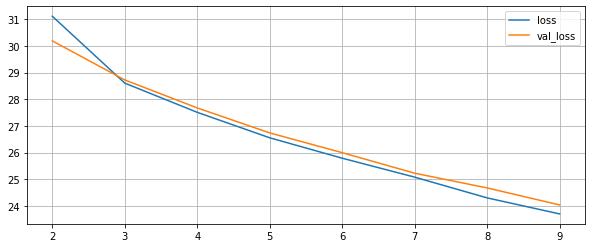

------------------------------------------= FOLD =------------------------------------------
Epoch 1/10
164/164 [==============================] - 1s 3ms/step - loss: 530.7601 - val_loss: 512.7571
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: 453.5939 - val_loss: 37.6276
Epoch 3/10
164/164 [==============================] - 0s 2ms/step - loss: 33.6072 - val_loss: 29.3838
Epoch 4/10
164/164 [==============================] - 0s 2ms/step - loss: 29.3582 - val_loss: 28.4131
Epoch 5/10
164/164 [==============================] - 0s 2ms/step - loss: 28.3253 - val_loss: 27.2363
Epoch 6/10
164/164 [==============================] - 0s 2ms/step - loss: 27.8341 - val_loss: 26.3605
Epoch 7/10
164/164 [==============================] - 0s 2ms/step - loss: 26.9391 - val_loss: 25.7285
Epoch 8/10
164/164 [==============================] - 0s 2ms/step - loss: 25.7050 - val_loss: 24.7238
Epoch 9/10
164/164 [==============================] - 0s 2ms/step - loss: 24.9246 - val_

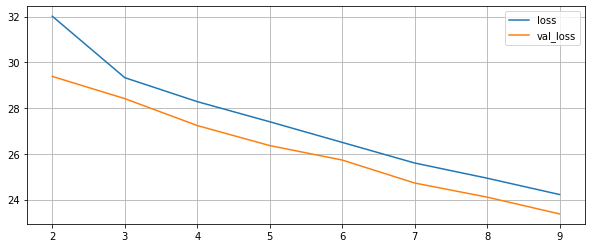

scores: 23.69 24.22 
média:  23.96


In [ ]:
# comandos para 'zerar' a biblioteca Keras e definir as sementes aleatórias
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# controle da validação cruzada
from sklearn.model_selection import KFold
kfold = KFold(random_state=42, shuffle=True, n_splits=2) # número de folds
scores = []
for fold_treino, fold_valid in kfold.split(X_treino, y_treino):
    # especificação do modelo
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation='relu', input_shape=[X_treino.shape[1]]),
      # keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(2, activation=None)
    ])

    # especificação da função de perda e do algoritmo de otimização
    model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.SGD(lr=0.01)) # taxa de aprendizado

    # treinamento
    print('------------------------------------------= FOLD =------------------------------------------')
    history = model.fit(X_treino[fold_treino], y_treino[fold_treino], epochs=10, # número de épocas
                        #callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                        validation_data=(X_treino[fold_valid], y_treino[fold_valid]))
    scores.append(history.history['loss'][-1])
    
    # exibição das funções de perda de treino e de validação, para cada época (eixo horizontal)
    pd.DataFrame(history.history).iloc[2:].plot(figsize=(10, 4))
    plt.grid(True)
    plt.show()
    
print('scores: ' + ('{:.2f} ' * len(scores)).format(*scores))
print('média:  {:.2f}'.format(np.mean(scores)))

# Geração de previsões e teste final do modelo de rede neural

In [ ]:
# previsões computadas para três instâncias de teste
y_predi = model.predict(tf.constant(X_teste[:3]))
print('previsões: ', y_predi[0].round(2), y_predi[1].round(2), y_predi[2].round(2))
print('rótulos:   ', y_teste[0].round(2), y_teste[1].round(2), y_teste[2].round(2))

previsões:  [495.02 570.48] [564.39 641.78] [510.43 588.27]
rótulos:    [505.22 696.47] [551.41 636.  ] [505.57 605.97]


In [ ]:
# avaliação com conjunto de teste
score_teste = model.evaluate(X_teste, y_teste)
print('score teste: {:.2f}'.format(score_teste))

83/83 [==============================] - 0s 2ms/step - loss: 23.8599
score teste: 23.86
